In [1]:
import os
import json
import argparse
import pprint as pp
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from datetime import timedelta

import networkx as nx
from scipy.spatial.distance import pdist, squareform
import torch
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from problems.tsp.problem_tsp import TSP
from utils import load_model, move_to
from train import set_decode_type

from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

In [52]:
class chgnn_opts:
    dataset_path = "data/tsp/tsp20_test_concorde.txt"
    batch_size = 16
    accumulation_steps = 1
    num_samples = 1280 # 1280 samples per TSP size 
    
    neighbors = 1
    knn_strat = None
        
    model = "outputs/tspsl_20-50/sl-ar-var-20pnn-chgnn-max_20250504T222109"
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")


class gnn_opts:
    dataset_path = "data/tsp/tsp20_train_concorde.txt"
    batch_size = 16
    accumulation_steps = 1
    num_samples = 1280 # 1280 samples per TSP size 
    
    neighbors = 1
    knn_strat = None
        
    model = "outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20250504T224226"
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")


 

In [53]:
chgnn_model, model_args = load_model(chgnn_opts.model, extra_logging=True)
chgnn_model.to(chgnn_opts.device)
set_decode_type(chgnn_model, "greedy")
chgnn_model.eval()

gnn_model, model_args = load_model(gnn_opts.model, extra_logging=True)
gnn_model.to(chgnn_opts.device)
set_decode_type(gnn_model, "greedy")
gnn_model.eval()

['args.json', 'epoch-9.pt']

Loading model from outputs/tspsl_20-50/sl-ar-var-20pnn-chgnn-max_20250504T222109/epoch-9.pt
['args.json', 'epoch-9.pt']

Loading model from outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20250504T224226/epoch-9.pt


/Users/olavforland/Documents/Harvard/classes/semester2/AM220/learning-tsp/utils/functions.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(load_path, m

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=64, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 64)
    (layers): ModuleList(
      (0-2): 3 x GNNLayer(
        (U): Linear(in_features=64, out_features=64, bias=True)
        (V): Linear(in_features=64, out_features=64, bias=True)
        (A): Linear(in_features=64, out_features=64, bias=True)
        (B): Linear(in_features=64, out_features=64, bias=True)
        (C): Linear(in_features=64, out_features=64, bias=True)
        (norm_h): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
    )
  )
  (project_node_embeddings): Linear(in_features=64, out_features=192, bias=False)
  (project_fixed_context): Linear(in_features=64, out_features=64, bias=False)
  (project_step_context): Linear(in_features=128, out_features=64, bias=False)
  (project_out): Linea

In [54]:
dataset = TSP.make_dataset(
    filename=chgnn_opts.dataset_path, batch_size=chgnn_opts.batch_size, num_samples=chgnn_opts.num_samples, 
    neighbors=chgnn_opts.neighbors, knn_strat=chgnn_opts.knn_strat, supervised=True
)
dataloader = DataLoader(dataset, batch_size=chgnn_opts.batch_size, shuffle=False, num_workers=0)


Loading from data/tsp/tsp20_test_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 51441.17it/s]


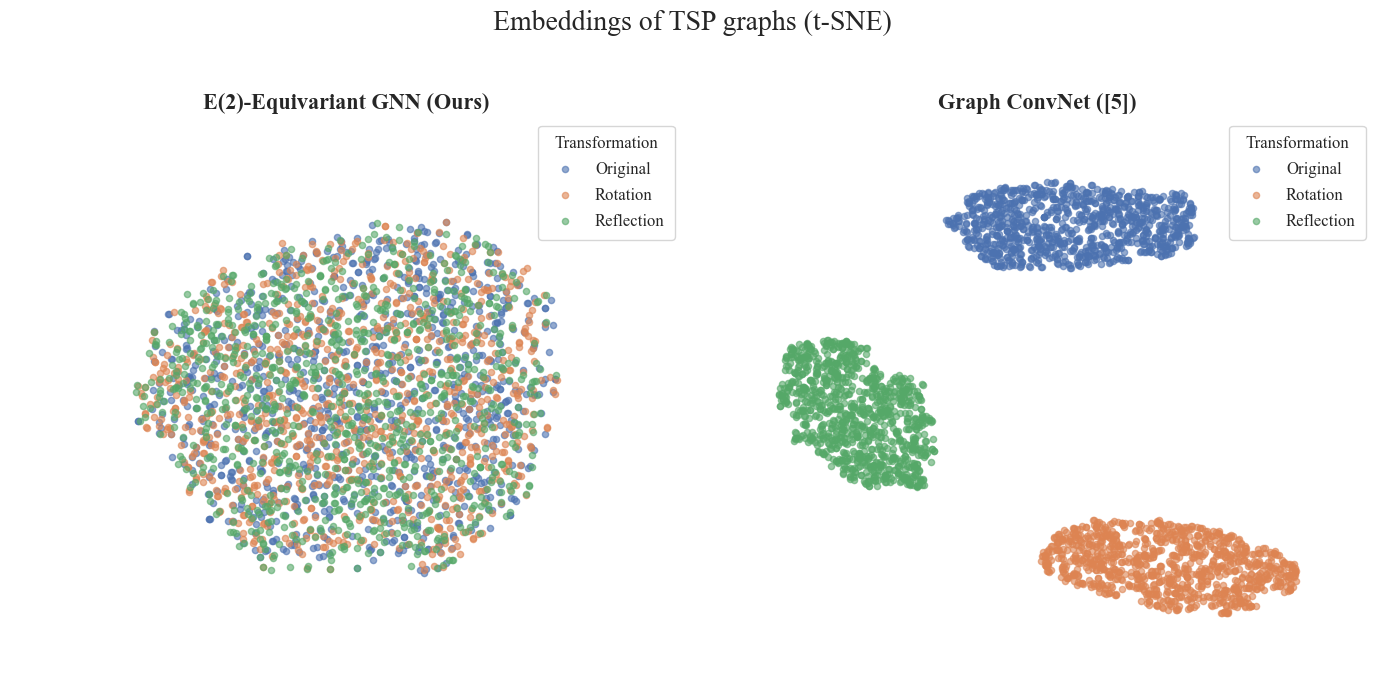

In [ ]:
import random
import math
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use serif font everywhere
plt.rcParams['font.family'] = 'serif'

# Parameters
num_subsamples = 1000
angle = math.pi / 4  # 45°

# Subsample dataset indices
indices = random.sample(range(len(dataset)), min(num_subsamples, len(dataset)))

def get_graph_embeddings(model, dataset, indices, device):
    embs = []
    labels = []
    model.eval()
    set_decode_type(model, 'greedy')
    for idx in indices:
        sample = dataset[idx]
        nodes0 = sample['nodes']
        graph0 = sample['graph']

        # Rotation matrix
        rot_mat = torch.tensor([
            [math.cos(angle), -math.sin(angle)],
            [math.sin(angle),  math.cos(angle)]
        ], dtype=nodes0.dtype)

        # Create variants
        nodes_rot = nodes0 @ rot_mat.T
        nodes_ref = nodes0.clone()
        nodes_ref[:, 0] *= -1  # reflect

        # Batch and move
        nodes_batch = torch.stack([nodes0, nodes_rot, nodes_ref], dim=0).to(device)
        graph_batch = graph0.unsqueeze(0).repeat(3, 1, 1).to(device)

        # Forward pass
        with torch.no_grad():
            _cost, _loss = model(nodes_batch, graph_batch, supervised=False)

        # Mean-pool
        emb = model.embeddings_batch.mean(dim=1).cpu()
        embs.append(emb)
        labels.extend(['Original', 'Rotation', 'Reflection'])

    return torch.cat(embs, dim=0).numpy(), labels

# Compute embeddings
embs1, labels = get_graph_embeddings(chgnn_model, dataset, indices, chgnn_opts.device)
embs2, _      = get_graph_embeddings(gnn_model,   dataset, indices, gnn_opts.device)

# Joint t-SNE
combined = np.concatenate([embs1, embs2], axis=0)
tsne = TSNE(n_components=2, init='random', random_state=42)
coords = tsne.fit_transform(combined)
coords1 = coords[:len(embs1)]
coords2 = coords[len(embs1):]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
colors = {'Original': 'C0', 'Rotation': 'C1', 'Reflection': 'C2'}

for ax, coords_set, title in zip([ax1, ax2], [coords1, coords2], ['E(2)-Equivariant GNN (Ours)', 'Graph ConvNet ([5])']):
    for lab in ['Original', 'Rotation', 'Reflection']:
        mask = [lbl == lab for lbl in labels]
        ax.scatter(coords_set[mask, 0], coords_set[mask, 1],
                   c=colors[lab], label=lab, alpha=0.6, s=20)
    ax.set_title(title, fontsize=16, fontfamily='serif')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    # ax.set_xlabel('t-SNE 1', fontsize=14)
    # ax.set_ylabel('t-SNE 2', fontsize=14)

for ax in (ax1, ax2):
    ax.legend(
        loc='upper right',
        ncol=1,
        frameon=True,
        fancybox=True,
        borderpad=0.6,
        labelspacing=0.6,
        prop={'family': 'serif', 'size': 12},
        title='Transformation',
        title_fontproperties={'family': 'serif'}
    )
ax1.margins(0.3)
ax2.margins(0.15)
# Legend
handles, labls = ax1.get_legend_handles_labels()
# fig.legend(handles, labls,
#            loc='upper center', ncol=3,
#            frameon=True, fancybox=True,
#            borderpad=0.6, labelspacing=0.6,
#            prop={'family': 'serif', 'size': 12},
#            title='Transformation',
#            title_fontproperties={'family': 'serif'})

fig.suptitle('Embeddings of TSP graphs (t-SNE)', fontsize=20, fontfamily='serif')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('graph_embedding_comparison.png',
            dpi=300,                # high resolution
            bbox_inches='tight',    # trim whitespace
            facecolor='white')      # ensure white background
plt.show()


In [5]:
tb_logger = SummaryWriter(os.path.join(
    model_args["log_dir"], "{}_{}-{}".format(model_args["problem"], model_args["min_size"], model_args["max_size"]), model_args["run_name"]))

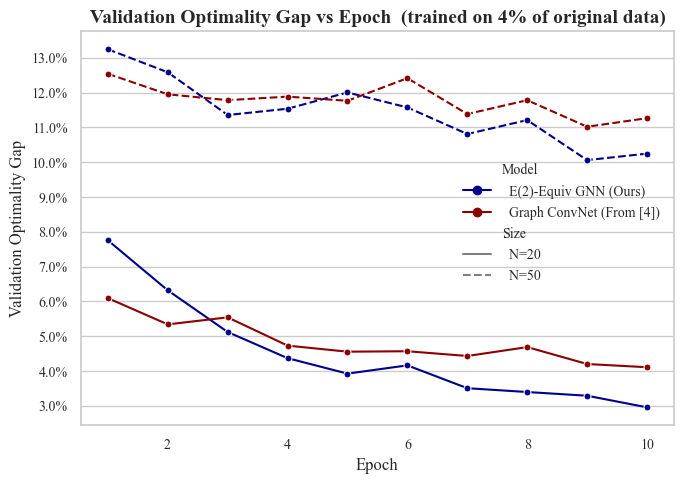

In [6]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_series(logdir, tag):
    # logdir should be the folder containing events.out.tfevents.*
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    evs = ea.Scalars(tag)
    return [e.step for e in evs], [e.value for e in evs]

# ← replace these paths with the exact ones you verified above
runs_to_plot = {
    "chgnn_20":   "logs/tspsl_20-50/sl-ar-var-20pnn-chgnn-max_20250504T222109",
    "gnn_20": "logs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20250504T224226",
    "chgnn_50":  "logs/tspsl_20-50/sl-ar-var-50pnn-chgnn-max_20250505T003006",
    "gnn_50": "logs/tspsl_20-50/sl-ar-var-50pnn-gnn-max_20250504T232502"
}
import os, glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# ------------------------------------------------------------------------------
# 0) Seaborn serif + whitegrid
# ------------------------------------------------------------------------------
sns.set_theme(
    style="whitegrid",
    font="serif",
    rc={
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Palatino", "serif"],
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

# ------------------------------------------------------------------------------
# 1) Color + linestyle maps
# ------------------------------------------------------------------------------
palette    = {"chgnn": "#00008B",  # deep blue
              "gnn":   "#8B0000"}  # deep red
linestyles = {"20":  "solid",
              "50":  "dashed"}

# ------------------------------------------------------------------------------
# 2) Batches per epoch
# ------------------------------------------------------------------------------
batches_per_epoch = 51200//16

# ------------------------------------------------------------------------------
# 3) Plot the curves (no legend yet)
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7,5))
for name, run_dir in runs_to_plot.items():
    ev = glob.glob(os.path.join(run_dir, "events.out.tfevents*"))
    if not ev:
        raise RuntimeError(f"No TB file under {run_dir}")

    tag = "val1/opt_gap" if name.endswith("_20") else "val2/opt_gap"
    steps, vals = load_series(run_dir, tag)
    epochs = [s / batches_per_epoch for s in steps]
    approach, size = name.split("_")

    sns.lineplot(
        x=epochs, y=vals, ax=ax,
        color=palette[approach],
        linestyle=linestyles[size],
        marker="o",
        markersize=5,
        legend=False
    )

# ------------------------------------------------------------------------------
# 4) Grid & axes tweaks
# ------------------------------------------------------------------------------
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Optimality Gap")
ax.set_title("Validation Optimality Gap vs Epoch  (trained on 4% of original data)")

# ------------------------------------------------------------------------------
# 5) Build a single legend with “Model” and “Size” sections
# ------------------------------------------------------------------------------
# Empty/heading handles (no line, no marker)
h_model_heading = Line2D([], [], linestyle="None", marker=None)
h_size_heading  = Line2D([], [], linestyle="None", marker=None)

# Actual style handles
h_chgnn = Line2D([], [], color=palette['chgnn'], marker='o', linestyle='solid')
h_gnn   = Line2D([], [], color=palette['gnn'],   marker='o', linestyle='solid')
h_20    = Line2D([], [], color='gray', linestyle=linestyles['20'])
h_50    = Line2D([], [], color='gray', linestyle=linestyles['50'])

handles = [
    h_model_heading,
    h_chgnn, h_gnn,
    h_size_heading,
    h_20,    h_50
]
labels = [
    "Model",
    "  E(2)-Equiv GNN (Ours)", "  Graph ConvNet (From [4])",
    "Size",
    "  N=20",  "  N=50"
]


leg = ax.legend(
    handles, labels,
    title="",
    frameon=False,
    borderpad=0.5,
    labelspacing=0.5,
    prop={'family': 'serif'},
    title_fontproperties={'family': 'serif'},
    loc='upper right',
    bbox_to_anchor=(1.0, 0.7)    # default is (1,1), so 0.98 shifts it down 2%
)



plt.tight_layout()
plt.show()


# 1) High-res PNG
fig.savefig(
    "val_opt_gap.png",
    dpi=300,               # 300 dots per inch (instead of the default 100)
    bbox_inches="tight"    # trim excess white space
)

In [7]:
dataset = TSP.make_dataset(
    filename=opts.dataset_path, batch_size=opts.batch_size, num_samples=opts.num_samples, 
    neighbors=opts.neighbors, knn_strat=opts.knn_strat, supervised=True
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=False, num_workers=0)


Loading from data/tsp/tsp10-200_concorde.txt...


100%|##########| 25600/25600 [00:02<00:00, 9532.29it/s] 
